In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import itertools # Importando itertools para generar combinaciones de columnas
# Importando la función seasonal_decompose para la descomposición de series temporales
#from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.patches as mpatches
import payments_manager as pm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
#pm.help()
#pm.reset()
#pm.init() #debug=True)
#cr_cp = pm.df('cr_cp')
#fe_cp = pm.df('fe_cp')
#cr_cp.info()
#fe_cp.info()

df_jo = pm.df('df_jo')
#df_jo.info()
df_jo = pm.sort("df_jo", ["id_cr"]).reset_index()
df_jo = df_jo.drop(columns=['index'])

df_jo_cp = df_jo.copy()


In [2]:
df_jo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32092 entries, 0 to 32091
Data columns (total 51 columns):
 #   Column                      Non-Null Count  Dtype          
---  ------                      --------------  -----          
 0   id_cr                       32092 non-null  int64          
 1   id_fe                       32092 non-null  int64          
 2   fe_cr_id                    21055 non-null  float64        
 3   user_id                     32092 non-null  int64          
 4   active                      32092 non-null  int64          
 5   created_at                  32092 non-null  datetime64[ns] 
 6   created_at_fe               21055 non-null  datetime64[ns] 
 7   amount                      32092 non-null  float64        
 8   fee                         32092 non-null  float64        
 9   stat_cr                     32092 non-null  object         
 10  stat_fe                     32092 non-null  object         
 11  transfer_type               32092 non-nul

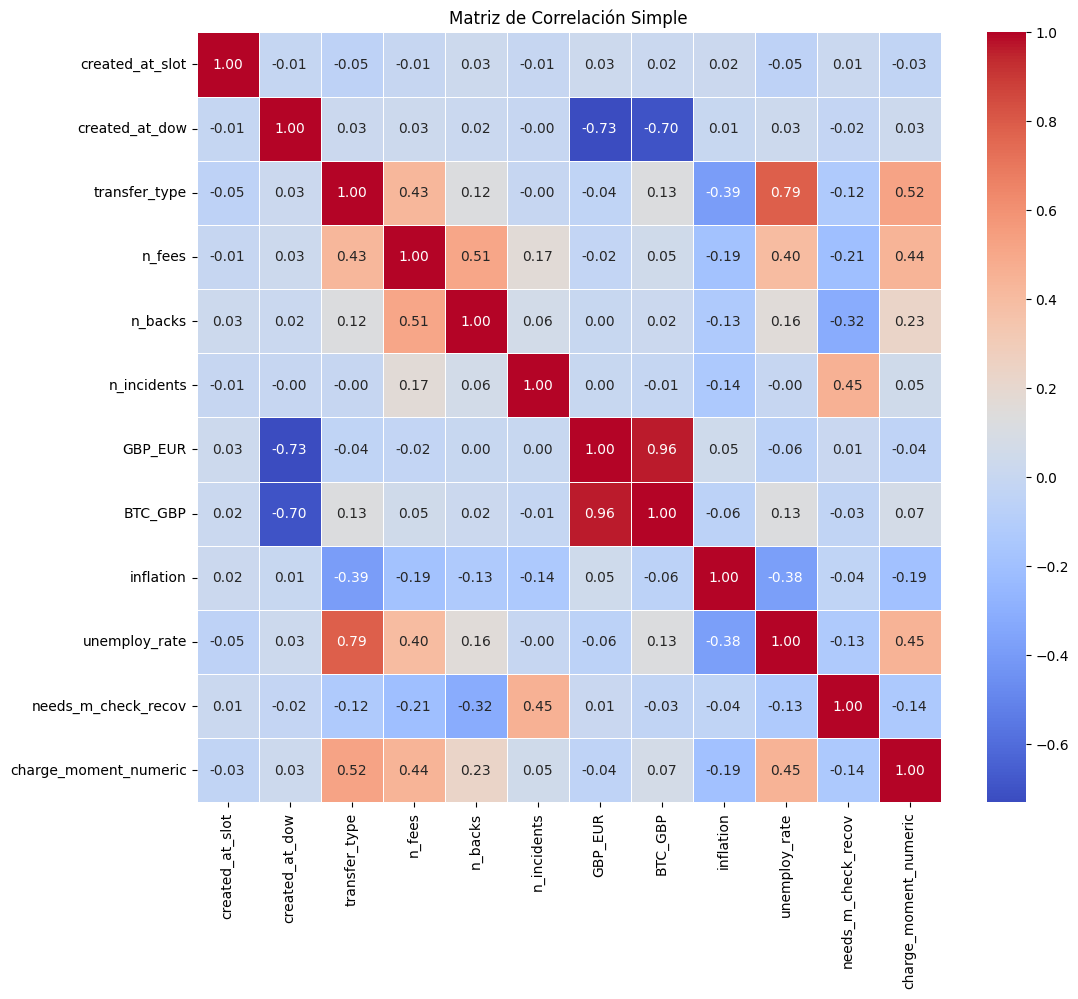

In [13]:
# Lista de columnas que deseas seleccionar del df_jo para el MODELO
columnas_deseadas = ['created_at_slot', 'created_at_dow' ,'transfer_type', 'n_fees', 'n_backs','n_incidents','charge_moment','GBP_EUR','BTC_GBP','inflation','unemploy_rate', 'needs_m_check_recov']

# Crear un nuevo DataFrame solamente con esas columnas
df_simpl = df_jo_cp[columnas_deseadas]

# Reasignar valores en la columna 'transfer_type' y 'charge_moment'
df_simpl = df_simpl.copy()
df_simpl['transfer_type'] = df_simpl['transfer_type'].map({'regular': 0, 'instant': 1})
df_simpl['charge_moment_numeric'] = df_simpl['charge_moment'].fillna('null').map({
    'before': 1,
    'after': 2,
    'null': 0  # Asigna -1 para los valores nulos llenados como 'null'
})

df_simpl=df_simpl.drop(columns=['charge_moment'])

df_simpl['GBP_EUR'] = df_simpl['GBP_EUR'].fillna(0)
df_simpl['BTC_GBP'] = df_simpl['BTC_GBP'].fillna(0)

# Calcular la matriz de correlación
m_corr_simpl = df_simpl.corr()

# Visualizar la matriz de correlación
plt.figure(figsize=(12, 10))
sns.heatmap(m_corr_simpl, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Matriz de Correlación Simple')
plt.show()

In [27]:
# Modelo de REGRESIÓN LOGÍSTICA 

# Crea la matriz de características y la var objetivo
X = df_simpl.drop(columns=['needs_m_check_recov','created_at_slot', 'charge_moment_numeric','created_at_dow' ,'transfer_type','BTC_GBP','unemploy_rate',])  # Elimina la columna objetivo
y = df_simpl['needs_m_check_recov']  # La columna de la variable objetivo

# Obtener los nombres de las características
feature_names = X.columns

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)

# Crea el clasificador de regresión logística. El 'liblinear' usa metodo de optimización de minimos cuadrados generalizados (L2) y soporta la regularización L1 y L2
clf = LogisticRegression(solver="liblinear")

# Entrena el clasificador
clf.fit(X_train, y_train)

# Realiza predicciones sobre el conjunto de prueba
predicciones = clf.predict(X_test)

#print (clf.coef_)

# Muestra las primeras 10 predicciones
#predicciones[:10]

# Genera las probabilidades de predicción
predicciones_probabilidades = clf.predict_proba(X_test)

# Muestra las primeras 10 probabilidades de predicción
#predicciones_probabilidades[:10]

# Obtén los coeficientes y asigna los nombres de las características
coeficientes = clf.coef_[0]  # clf.coef_ es un array bidimensional, tomamos la primera fila
feature_coef = list(zip(feature_names, coeficientes))

# Ordena las características por el valor absoluto del coeficiente en orden descendente
feature_coef_sorted = sorted(feature_coef, key=lambda x: abs(x[1]), reverse=True)

# Imprime cada variable junto con su coeficiente ordenado
print("Coeficientes del modelo de regresión logística (ordenados por magnitud):")
for feature, coef in feature_coef_sorted:
    print(f"{feature}: {coef:.4f}")



Coeficientes del modelo de regresión logística (ordenados por magnitud):
n_incidents: 1.1531
n_backs: -0.7613
n_fees: -0.6563
inflation: -0.4450
GBP_EUR: 0.0523


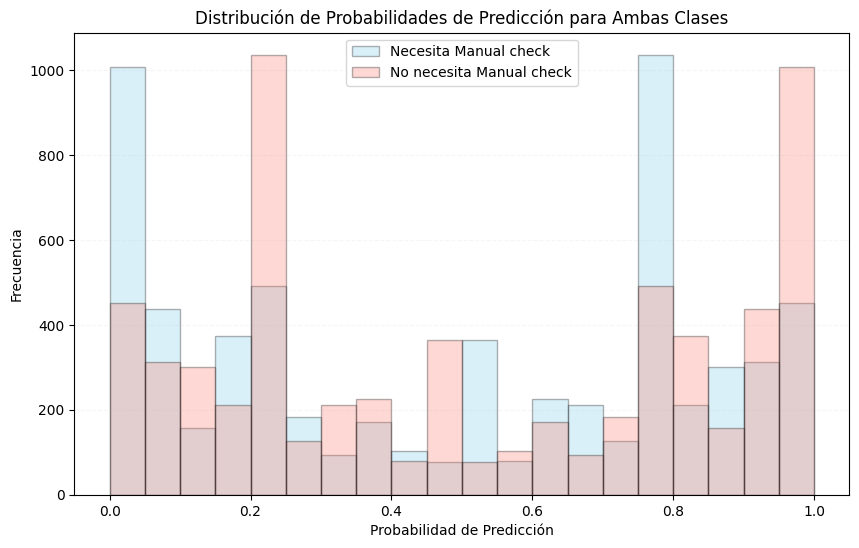

In [28]:
# Crea un histograma de las probabilidades de predicción para ambas clases
plt.figure(figsize=(10, 6)) 

# # Histograma para la clase negativa (need manual check)
plt.hist(predicciones_probabilidades[:, 0], bins=20, color="skyblue", edgecolor="black", alpha=0.3, label="Necesita Manual check")
# Histograma para la clase positiva (no need manual check)
plt.hist(predicciones_probabilidades[:, 1], bins=20, color="salmon", edgecolor="black", alpha=0.3, label="No necesita Manual check")
# Título y etiquetas de los ejes
plt.title("Distribución de Probabilidades de Predicción para Ambas Clases")
plt.xlabel("Probabilidad de Predicción")
plt.ylabel("Frecuencia")
plt.legend(loc="upper center") 
# Muestra la leyenda en el gráfico
plt.grid(axis="y", linestyle="--", alpha=0.1)
plt.show()

In [29]:
# Generamos Df para comparar realidad vs predicción

# Crea un DataFrame con las probabilidades de predicción
probs_df = pd.DataFrame(predicciones_probabilidades)

# Reinicia el índice y crea una copia de los datos de prueba
X_2 = X_test.reset_index().copy()
X_2["needs_m_check_recov"] = y_test.tolist()

# Combina los datos de prueba con las probabilidades de predicción
X_2["prediccion"] = predicciones
X_2 = pd.concat([X_2, probs_df], axis=1)

# Muestra las primeras 20 filas de comparación
X_2[["needs_m_check_recov", "prediccion", 0, 1]].head(10)

,needs_m_check_recov,prediccion,0,1
0,0,0,0.781082,0.218918
1,1,1,0.214409,0.785591
2,1,1,0.051499,0.948501
3,0,0,0.984066,0.015934
4,1,1,0.006585,0.993415
5,1,1,0.410192,0.589808
6,1,0,0.805179,0.194821
7,1,0,0.562764,0.437236
8,1,1,0.073064,0.926936
9,1,0,0.594744,0.405256


Accuracy: 0.8625954198473282
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.91      0.86      3003
           1       0.91      0.82      0.86      3416

    accuracy                           0.86      6419
   macro avg       0.86      0.87      0.86      6419
weighted avg       0.87      0.86      0.86      6419



Text(70.5815972222222, 0.5, 'Realidad')

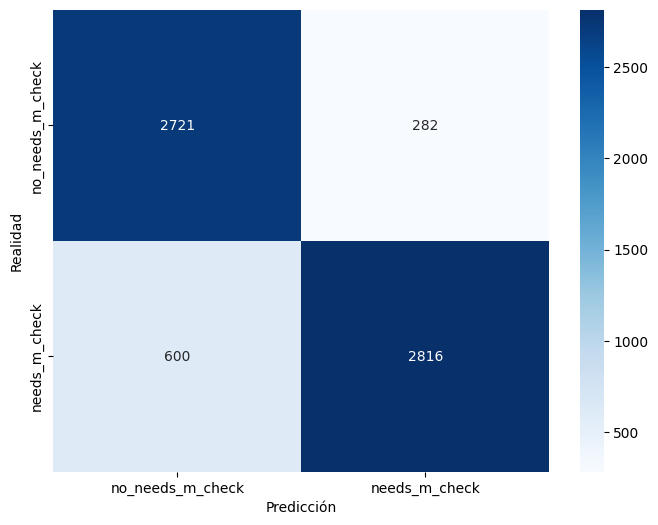

In [30]:
# Importa la función para crear la matriz de confusión
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluate model performance
print("Accuracy:", clf.score(X_test, y_test))  # Accuracy score
print("Classification Report:\n", classification_report(y_test, predicciones))  # Classification report


# Genera la matriz de confusión
matriz_confusion = confusion_matrix(y_test, predicciones)
columnas = ['no_needs_m_check', 'needs_m_check'] # 0 para No necesita manual check y 1 para Sí necesita manual check

# Visualiza la matriz de confusión utilizando un mapa de calor

plt.figure(figsize=(8, 6))
sns.heatmap(matriz_confusion, annot=True, fmt='d', cmap='Blues', xticklabels=columnas, yticklabels=columnas)
plt.xlabel("Predicción")
plt.ylabel("Realidad")

ROC AUC Score: 0.92


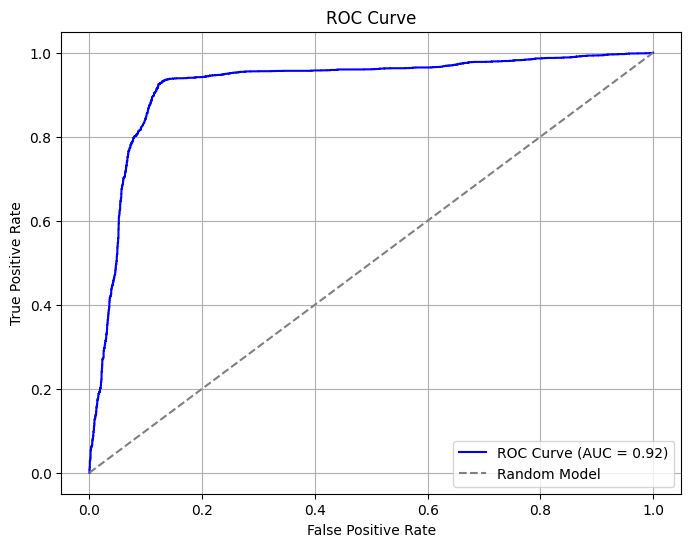

In [ ]:
# Evaluación ROC AUC, para ver qué tan bien separa las clases nuestro modelo de Regresion LOGISTICA

from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Obtén las probabilidades predichas para la clase positiva
y_pred_prob = clf.predict_proba(X_test)[:, 1]

# Calcula el AUC
auc_score = roc_auc_score(y_test, y_pred_prob)
print(f"ROC AUC Score: {auc_score:.2f}")

# Calcula los puntos de la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Grafica la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc_score:.2f})", color="blue")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Model")
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()